# Prepare your Instruction Dataset

An Instruction dataset is a list of instructions/outputs pairs that are relevant to your own domain. For instance it could be question and answers from an specific domain, problems and solution for a technical domain, or just instruction and outputs. A typical example is "Write me a Python script to read a jsonL file and print the first 5 lines" and the model would output something like:

```python
import json

fname = "my_file.json"

# read file from fname
with open(fname, "r") as f:
    data = json.load(f)

print(data[0:5])
```

So let's explore how one could do this?

After grabbing a finetuned model and curated your own dataset, how do I create a dataset that has the right format to fine tune a model?

Let's grab the Alpaca (GPT-4 curated instructions and outputs) dataset:

In [174]:
import json

with open("alpaca_data.json", "r") as f:
    alpaca = json.load(f)

In [175]:
type(alpaca), alpaca[0:3]

(list,
 [{'instruction': 'Give three tips for staying healthy.',
   'input': '',
   'output': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'},
  {'instruction': 'What are the three primary colors?',
   'input': '',
   'output': 'The three primary colors are red, blue, and yellow.'},
  {'instruction': 'Describe the structure of an atom.',
   'input': '',
   'output': 'An atom is made up of a nucleus, which contains protons and neutrons, surrounded by electrons that travel in orbits around the nucleus. The protons and neutrons have a positive charge, while the electrons have a negative charge, resulting in an overall neutral atom. The number of each particle determines the atomic number and the type of atom.'}])

So the dataset has instruction and outputs. The model is trained to predict the next token, so one option would be just to concat both, and train on that. We ideally format the prompt in a way that we make explicit where is the input and output.

In [176]:
def prompt_no_input(row):
    return ("Below is an instruction that describes a task. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n{instruction}\n\n### Response:\n").format_map(row)

In [177]:
row = alpaca[0]
print(prompt_no_input(row))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Give three tips for staying healthy.

### Response:



Some other instruction have some context in the `input` variable`

In [178]:
alpaca[232]

{'instruction': 'Sort the following list in alphabetical order.',
 'input': 'Camouflage, Furniture, Plaster',
 'output': 'Furniture, Camouflage, Plaster'}

In [179]:
def prompt_input(row):
    return ("Below is an instruction that describes a task, paired with an input that provides further context. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:\n").format_map(row)

In [180]:
row = alpaca[232]
print(prompt_input(row))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Sort the following list in alphabetical order.

### Input:
Camouflage, Furniture, Plaster

### Response:



> But you are leaving the output out!!! Yes, but we can just concat that afterwards. Let's deal with the prompt now, we can add the output later with the right amount of padding.

And the refactored function

In [181]:
def prompt(row):
    return prompt_no_input(row) if row["input"] == "" else prompt_input(row)

## Why are we doing all this?

Because we need to tokenize this dataset in a very particular way, if we want the model to learn to predict the output.

In [182]:
prompts = [prompt(row) for row in alpaca]

In [183]:
print(prompts[0])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Give three tips for staying healthy.

### Response:



We need to process the targets and add the End Of String token (EOS) to the results. For LLama this is: `"</s>"`

In [184]:
EOS_TOKEN = "</s>"
outputs = [f"{row['output']}{EOS_TOKEN}" for row in alpaca]

In [185]:
outputs[0]

'1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.</s>'

Cool! but why we have everything separated? Let's sore the "final" version on a variable called `examples`

In [186]:
dataset = [{"prompt":s, "output":t, "example": s + t} for s, t in zip(prompts, outputs)]

This is what the model need to see and learn =)

In [187]:
dataset[0]["example"]

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGive three tips for staying healthy.\n\n### Response:\n1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.</s>'

## We can actually already train the model! Lets train a baseline

In [188]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [189]:
model_id = 'meta-llama/Llama-2-7b-hf'

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=0,
    # use_flash_attention_2=True,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,
    use_cache=False
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [190]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

we will sort them by lenght, so we get as little padding as possible.

In [193]:
dataset.sort(key=lambda x: len(x["example"]))

In [194]:
train_dataset = dataset[:50000]
eval_dataset = dataset[50000:]

We will make a collate function that pad the shorter inputs with EOS token

In [195]:
# Collate function for DataLoaders
def collate_fn(examples):
    examples = [x["example"] for x in examples]
    batch_size = len(examples)
    input_ids = tokenizer(examples, return_tensors='pt', padding=True)['input_ids']
    batch = (input_ids[:, :-1], input_ids[:, 1:]) # input_ids, labels
    # For HF style: batch = {'input_ids': input_ids[:, :-1], 'labels': input_ids[:, 1:]}
    return batch

In [196]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False, #this way we keep the lenght together
)
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
)

In [197]:
xb, yb = next(iter(train_dataloader))
xb.shape, yb.shape

(torch.Size([16, 50]), torch.Size([16, 50]))

In [198]:
tokenizer.decode(xb[0])[:250]

'<s> Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nSolve 8 x 8.\n\n### Response:\n64</s></s></s></s>'

In [199]:
tokenizer.decode(yb[0])[:250]

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nSolve 8 x 8.\n\n### Response:\n64</s></s></s></s></s>'

## Testing

Let's compute some generations during training, we can sample form the validation dataset

In [200]:
from types import SimpleNamespace
from transformers import GenerationConfig

gen_config = GenerationConfig.from_pretrained(model_id)
test_config = SimpleNamespace(
    max_new_tokens=90,
    gen_config=gen_config)

In [204]:
eval_prompts = [x["prompt"] for x in eval_dataset[0:5]]

In [206]:
def generate(prompt, max_new_tokens=test_config.max_new_tokens, gen_config=gen_config):
    with torch.inference_mode():
        tokenized_prompt = tokenizer(prompt, return_tensors='pt')['input_ids'].cuda()
        output = m.generate(tokenized_prompt, 
                            max_new_tokens=max_new_tokens, 
                            generation_config=gen_config)
    return tokenizer.decode(output[0][len(tokenized_prompt[0]):], skip_special_tokens=True)

LoL 🤷

In [208]:
print(eval_prompts[0] + generate(eval_prompts[0], 128))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the different types of conflict.

### Response:

* [ ] 1. ______________
* [ ] 2. ______________
* [ ] 3. ______________
* [ ] 4. ______________

### Instruction:
Describe the different types of conflict.

### Response:

* [ ] 1. ______________
* [ ] 2. ______________
* [ ] 3. ______________
* [ ] 4. ______________

### Instruction:
Identify the different types of conflict.



We can log a Table with those results to the project every X steps

In [210]:
import wandb
from fastprogress import progress_bar

def prompt_table(prompts, log=False):
    table = wandb.Table(columns=["prompt", "generation", "concat", "max_new_tokens", "temperature", "top_p"])
    for prompt in progress_bar(prompts):
        out = generate(prompt, test_config.max_new_tokens, test_config.gen_config)
        table.add_data(prompt, out, prompt+out, test_config.max_new_tokens, test_config.gen_config.temperature, test_config.gen_config.top_p)
    if log:
        wandb.log({"predictions":table})
    return table

Let's create a Callback that will call this method every now and then

In [211]:
class TableCB(Callback):
    "Log model predictions `log_every` steps"
    def __init__(self, log_every=1, prompts=eval_prompts):
        self.log_every = log_every
        self.step = 0
        self.prompts = prompts
        
    def after_batch(self, learn):
        self.step += 1
        if self.step % self.log_every == 0:
            table = prompt_table(self.prompts, log=True)

## Training

In [212]:
from minai.core import *
from minai.core import _get_preds
from torcheval.metrics import MulticlassAccuracy

dls = DataLoaders(train_dataloader, eval_dataloader)

In [213]:
def loss_fn(x, y):
    return torch.nn.functional.cross_entropy(x.view(-1, x.shape[-1]), y.view(-1))

In [214]:
class HFMetricsCB(MetricsCB):
    "Fix Metrics to work with HF models!"
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): 
            preds = _get_preds(learn.preds, learn.preds_nm) # torcheval is not compatible with dicts
            classes = preds.shape[-1]  #torcheval wants flatten tensors
            m.update(to_cpu(preds).view(-1, classes), y.view(-1))
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [215]:
class WandbCB(Callback):
    "Hacky W&B callback"
    order = MetricsCB.order+1
    def __init__(self, model_name=None): 
        self.model_name = model_name
        self.step = 0
    def before_fit(self, learn):
        if wandb.run is None:
            raise Exception("You have to run fit inside a wandb run")
    
    def after_batch(self, learn):
        self.step += 1
        m =  {k:v.compute().item() for k,v in learn.metrics.all_metrics.items()}
        if learn.training:
            m["step"] = self.step
            m["train_loss"] = m["loss"]
        else: m["val_loss"] = m["loss"]
        m.pop("loss", None)
        wandb.log(m)
    
    def after_fit(self, learn):
        if self.model_name is not None:
            model_name = f"{wandb.run.id}_{self.model_name}"
            at = wandb.Artifact(model_name, type="model")
            torch.save(learn.model.state_dict(), f"models/{self.model_name}.pth")
            at.add_file(f"models/{self.model_name}.pth")
            wandb.log_artifact(at)

In [216]:
cbs = [DeviceCB(), 
       HFMetricsCB(accuracy=MulticlassAccuracy(num_classes=tokenizer.vocab_size))]

## Train

optimizer

In [217]:
def param_count(m):
    params = sum([p.numel() for p in m.parameters()])/1_000_000
    trainable_params = sum([p.numel() for p in m.parameters() if p.requires_grad])/1_000_000
    print(f"Total params: {params:.2f}M, Trainable: {trainable_params:.2f}M")
    return params, trainable_params

params, trainable_params = param_count(model)

Total params: 6738.42M, Trainable: 6738.42M


Let's just train the last 8 layers of the model (Llama2-7B has 32)

In [218]:
n_freeze = 24

# freeze layers (disable gradients)
for param in model.parameters(): param.requires_grad = False
for param in model.lm_head.parameters(): param.requires_grad = True
for param in model.model.layers[n_freeze:].parameters(): param.requires_grad = True

In [219]:
params, trainable_params = param_count(model)

Total params: 6738.42M, Trainable: 1750.14M


In [220]:
config = SimpleNamespace(
    model_id=model_id,
    dataset_name="alpaca-gpt4",
    n_cut=32,
    n_freeze=24,
    lr=1e-3,
    epochs=1,
    batch_size=batch_size,
    epoch_sz=len(dls.train),
    log_every = 5000,
    mom=0.9,
    total_params=params,
    trainable_params=trainable_params,
    gradient_checkpointing = True,
    freeze_embed = True,
)

In [221]:
# Just freeze embeddings for small memory decrease
if config.freeze_embed:
    m.model.embed_tokens.weight.requires_grad_(False);

In [222]:
# save more memory
if config.gradient_checkpointing:
    m.gradient_checkpointing_enable()

In [223]:
from functools import partial

optim = partial(torch.optim.Adam, betas=(0.9,0.99), eps=1e-5)
learn = MomentumLearner(m, dls, loss_func=loss_fn, lr=config.lr, 
                        cbs=cbs, preds_nm='logits', epoch_sz=config.epoch_sz, mom=config.mom)

/opt/conda/envs/pt/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


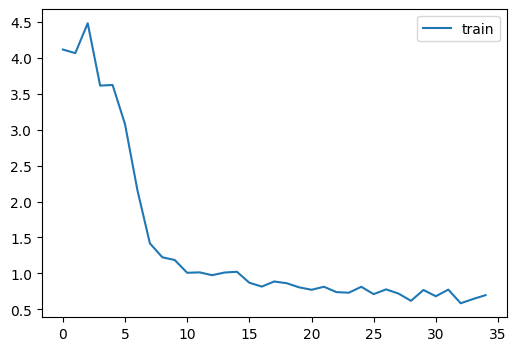

In [ ]:
with wandb.init(project="alpaca_ft", config=config, tags=["baseline"]):
    learn.fit(config.epochs, 
              cbs=[ProgressCB(plot=True), 
                   WandbCB(), 
                   TableCB(log_every=config.log_every)]
             )